In [1]:
# Face Swap with Delaunay Triangles for Single Destination Image #

In [2]:
# Importing Libraries

import cv2
import dlib
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageStat

In [3]:
# Getting Source and Destination File Paths

source = "./images/source1.jpg"
print("Source Image:     ", source)

destination = "./images/destination1.jpg"
print("Destination Image:", destination)

Source Image:      ./images/source1.jpg
Destination Image: ./images/destination1.jpg


Source Image: ./images/source1.jpg


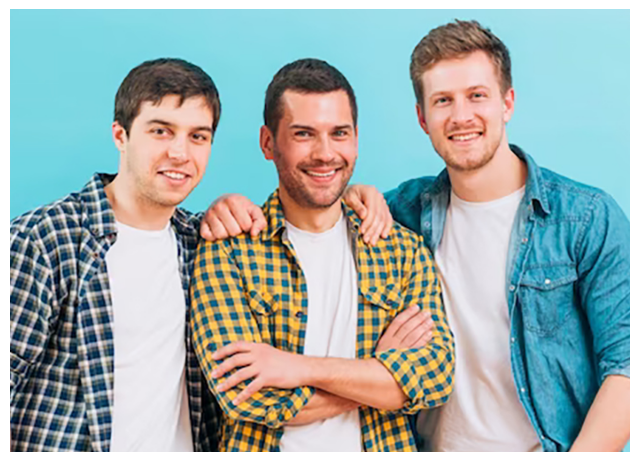

In [4]:
# Plotting the Source Image

print(f"Source Image: {source}")
source_image = cv2.imread(source, 1)
i = source_image.shape[1] / source_image.shape[0]
plt.figure(figsize=(int(6 * i), 6)); plt.axis('off')
plt.imshow(cv2.cvtColor(source_image, cv2.COLOR_BGR2RGB));

Destination Image: ./images/destination1.jpg


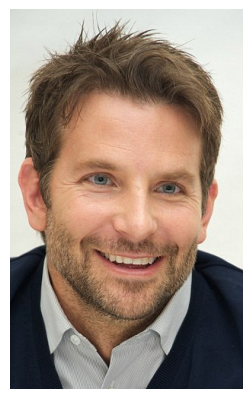

In [5]:
# Plotting the Destination Image

print(f"Destination Image: {destination}")
destination_image = cv2.imread(destination, 1)
i = destination_image.shape[1] / destination_image.shape[0]
plt.figure(figsize=(int(6 * i), 6)); plt.axis('off')
plt.imshow(cv2.cvtColor(destination_image, cv2.COLOR_BGR2RGB));

In [6]:
# Loading the Images

face = cv2.imread(source, 1)
body = cv2.imread(destination, 1)

In [7]:
# Loading Models and Predictors From the 'dlib' Library to Detect Landmarks on Both Faces

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("./src/shape_predictor_68_face_landmarks.dat")

source_faces = len(detector(face, 1))
destination_faces = len(detector(body, 1))

print(f"Number of Faces in the Source Image:      {source_faces}")
print(f"Number of Faces in the Destination Image: {destination_faces}")

Number of Faces in the Source Image:      3
Number of Faces in the Destination Image: 1


In [8]:
# Detecting Face Regions by Using Shape Predictor

def face_detector(img):
    # loading the Face Detector and the Shape Predictor
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("./src/shape_predictor_68_face_landmarks.dat")

    # Reading the Input Image and Converting It to Grayscale
    image = cv2.imread(img)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detecting the Face Regions
    rects = detector(gray, 1)

    # Defining A List of Polylines
    polylines_all = []

    # Going Through All the Face Bounding Boxes
    for rect in rects:

        # Getting A Fresh Copy of the Original Image for Each Face ROI
        image_cp = image.copy()

        # Applying the Shape Predictor to Each Face ROI
        landmarks = predictor(gray, rect)
        # Defining A List for the 68 Landmark Points
        landmarks_points = []

        def get_landmarks(landmarks, landmarks_points):
            for n in range(68):
                x = landmarks.part(n).x
                y = landmarks.part(n).y
                landmarks_points.append((x, y))

        # Landmarks are Stored in "landmarks_points"
        get_landmarks(landmarks, landmarks_points)

        # Drawing A Convex Hull over the Detected 68 Landmarks of the Current Face
        points = np.array(landmarks_points, np.int32)
        convexhull = cv2.convexHull(points)

        # Adding the Current Convex Hull on the Source Image
        polylines_all.append(cv2.polylines(image_cp, [convexhull], True, (255, 255, 255), 2))

    # Returning the List of Convex Hulls on Each Individual Face
    return polylines_all

Choose the Source Face to Place over the Destination Faces:
Face Index: 0, 1, 2

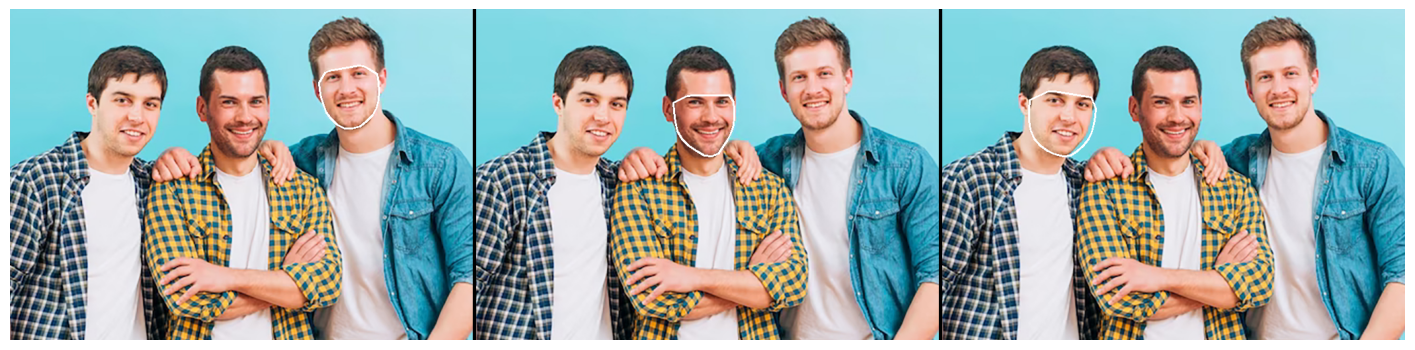

In [9]:
# Plotting the List of Images with Different Convex Hulls on Each Individual Face

# Getting the Height Value of the Source Image for the Thickness of Borderline 
img = cv2.imread(source)
h_src = img.shape[0]
w_src = img.shape[1]
border = np.zeros((h_src, int(h_src / 100), 3), dtype=np.uint8)

print("Choose the Source Face to Place over the Destination Faces:")
print("Face Index: ", end="")

detected_faces = face_detector(source)

first = True
facenum = 0
for source_face in detected_faces:
    if first:
        print(f"{facenum}", end="")
        all_faces = source_face
        facenum += 1
        first = False
    else:
        print(f", {facenum}", end="")
        all_faces = cv2.hconcat([all_faces, border, source_face])
        facenum += 1

i = len(detected_faces)
plt.figure(figsize=(int(6 * i), 6)); plt.axis('off')
plt.imshow(cv2.cvtColor(all_faces, cv2.COLOR_BGR2RGB));

In [10]:
# Specifying the Index Number of the Face That You Want to Place over the Destination Faces

###########################
###########################

facenum = 1

###########################
###########################

Destination Image: ./images/destination1.jpg


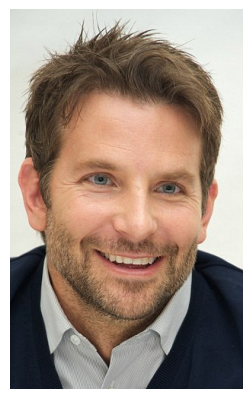

In [11]:
# Remembering the Destination Image

print(f"Destination Image: {destination}")
destination_image = cv2.imread(destination, 1)
i = destination_image.shape[1] / destination_image.shape[0]
plt.figure(figsize=(int(6 * i), 6)); plt.axis('off')
plt.imshow(cv2.cvtColor(destination_image, cv2.COLOR_BGR2RGB));

In [12]:
# Detecting If Any of the Processed Images is Gray / Black & White

def detect_grayscale(file, thumb_size=50, mse_limit=30, adjust_color_bias=True):
    opencv_image = cv2.imread(file, cv2.IMREAD_UNCHANGED)
    img = Image.fromarray(opencv_image)
    # pil_img = Image.open(file)

    bands = img.getbands()
    if bands == ('R', 'G', 'B') or bands == ('R', 'G', 'B', 'A'):
        thumb = img.resize((thumb_size, thumb_size))
        sse, bias = 0, [0, 0, 0]

        if adjust_color_bias:
            bias = ImageStat.Stat(thumb).mean[:3]
            bias = [b - sum(bias) / 3 for b in bias]

        for pixel in thumb.getdata():
            mu = sum(pixel) / 3
            sse += sum((pixel[i] - mu - bias[i]) * (pixel[i] - mu - bias[i]) for i in [0, 1, 2])

        mse = float(sse) / (thumb_size * thumb_size)

        if mse <= mse_limit:   # If Not Colored
            return True

        else:                  # If Colored
            return False

    else:                      # If Not Colored
        return True

print("Grayscale Source:     ", detect_grayscale(source))
print("Grayscale Destination:", detect_grayscale(destination))

Grayscale Source:      False
Grayscale Destination: False


In [13]:
# If the Source is Colored and the Destination is Gray, the Source is Converted to Grayscale
# If the Source is Gray and the Destination is Colored, the Source is Colorized
# As a Result, the Final Image will Have Consistent Color Distributions

if detect_grayscale(destination) and not detect_grayscale(source):

    face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
    face = cv2.cvtColor(face, cv2.COLOR_GRAY2BGR)
    print("The source image is converted to grayscale.")

elif detect_grayscale(source) and not detect_grayscale(destination):

    from cv2 import dnn

    # Assigning Model File Paths
    prototxt = './src/colorization_deploy_v2.prototxt'
    caffemodel = './src/colorization_release_v2.caffemodel'
    hull = './src/pts_in_hull.npy'

    # Loading Model & Proto Files and Hull Points from Disk
    net = cv2.dnn.readNetFromCaffe(prototxt, caffemodel)
    pts = np.load(hull)

    # Adding the Cluster Centers as 1x1 Convolutions to the Model
    layer_class8 = net.getLayerId("class8_ab")
    layer_conv8 = net.getLayerId("conv8_313_rh")
    pts = pts.transpose().reshape(2, 313, 1, 1)
    net.getLayer(layer_class8).blobs = [pts.astype("float32")]
    net.getLayer(layer_conv8).blobs = [np.full([1, 313], 2.606, dtype="float32")]

    # Loading the Input Image
    #image = cv2.imread(source, 1)
    image = face
    
    # Converting Image from BGR to RGB
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Normalizing the Image by Changing Pixel Values to the Range of [0, 1]
    normalized = image.astype("float32") / 255.0
    # Converting the Normalized Image from BGR to LAB Color Space
    #lab_image = cv2.cvtColor(normalized, cv2.COLOR_RGB2LAB)
    lab_image = cv2.cvtColor(normalized, cv2.COLOR_BGR2LAB)
    
    # Resizing the Lab Image to 224 x 224
    resized_lab_image = cv2.resize(lab_image, (224, 224))
    # Splitting Channels and Extracting the 'L' Channel
    L = cv2.split(resized_lab_image)[0]
    # Mean Centering
    L -= 50

    # Sending 'L' Channel to the Network to Predict 'a' and 'b' Channel Values
    net.setInput(cv2.dnn.blobFromImage(L))
    # Finding the Values of 'a' and 'b' Channels
    ab = net.forward()[0, :, :, :].transpose((1, 2, 0))
    # Resizing the Predicted 'ab' Volume to the Input Image Size
    ab = cv2.resize(ab, (image.shape[1], image.shape[0]))

    # Grabbing the 'L' Channel from the Original Input Image
    L = cv2.split(lab_image)[0]
    # Concatenating the Original 'L' Channel with the Predicted 'ab' Channels
    lab_colorized = np.concatenate((L[:, :, np.newaxis], ab), axis=2)

    # Converting the Output Image from the LAB Color Space to RGB
    #rgb_colorized = cv2.cvtColor(lab_colorized, cv2.COLOR_LAB2RGB)
    bgr_colorized = cv2.cvtColor(lab_colorized, cv2.COLOR_LAB2BGR)
    # Clipping Any Values that Fall Outside the Range of [0, 1]
    bgr_colorized = np.clip(bgr_colorized, 0, 1)

    # Converting the Colorized Image from "Float" in [0, 1] to Unsigned 8-bit "Int" in: [0, 255]
    bgr_colorized = (255 * bgr_colorized).astype("uint8")

    face = bgr_colorized

    print("The Source Image is Colorized!")

else:

    print("No Change in Colors of the Source Image!");

No Change in Colors of the Source Image!


Source & Destination Images Concatenated Horizontally:


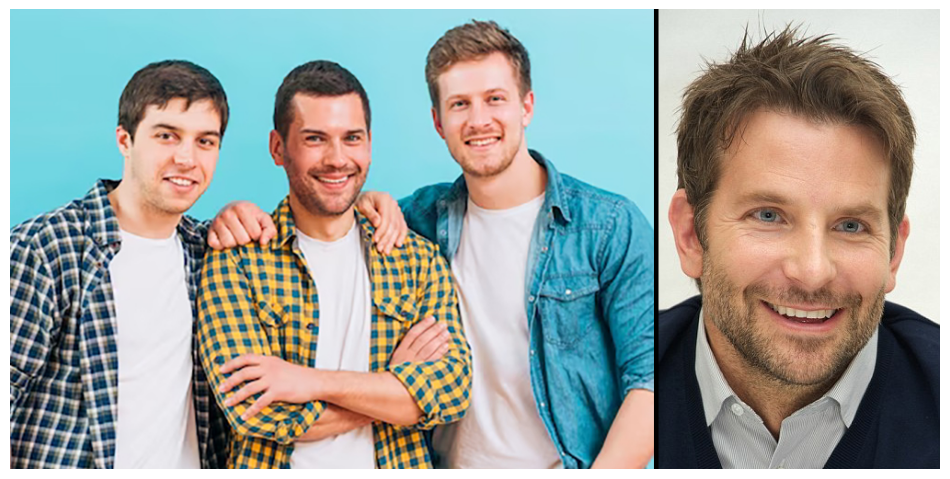

In [14]:
# Plotting Both the Source and the Destination Images as Concatenated

# Adjusting the Height and Width Values for Plotting
h_src = face.shape[0]
w_src = face.shape[1]
h_des = body.shape[0]
w_des = int((h_des * w_src) / h_src)
border = np.zeros((h_des, int(h_des / 100), 3), dtype=np.uint8)

# Concatenated Final Image to Plot
show_results = cv2.hconcat([cv2.resize(face, (w_des, h_des)), border, body])

# Plotting the Source & Destination Images Together
i = show_results.shape[1] / show_results.shape[0]
plt.figure(figsize=(int(6 * i), 6)); plt.axis('off')
print("Source & Destination Images Concatenated Horizontally:")
plt.imshow(cv2.cvtColor(show_results, cv2.COLOR_BGR2RGB));

In [15]:
# Converting Images to Grayscale Before the Face Swap Operation

face_gray = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
body_gray = cv2.cvtColor(body, cv2.COLOR_BGR2GRAY)

Source Face:


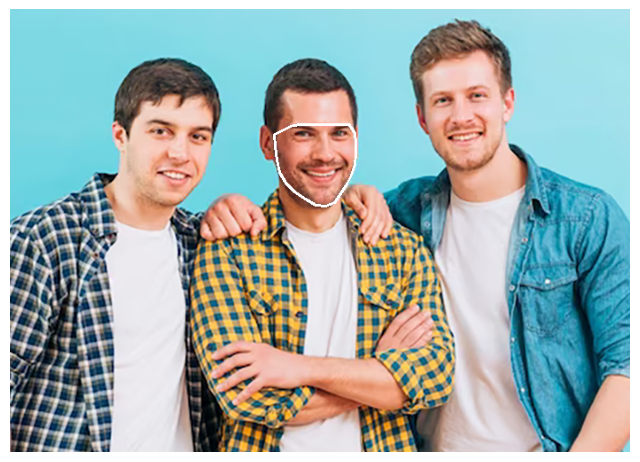

In [16]:
# Loading Models and Predictors of the 'dlib' Library to Detect Landmarks in Faces
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("./src/shape_predictor_68_face_landmarks.dat")

# Detecting Faces in the Source Image
rects = detector(face_gray, 1)

if len(rects) == 0:
    print("The Source Image does not Have Any Face!")
    # Exit Program or Request a New Source File!
else:
    print("Source Face:")
    # Getting the Face with the Index That was Specified Before
    rect = rects[facenum]

    # Detecting 68 Landmark Points in the Face and Finding Its (x, y) Coordinates
    landmarks = predictor(face_gray, rect)
    landmarks_points = []


    def get_landmarks(landmarks, landmarks_points):
        for n in range(68):
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            landmarks_points.append((x, y))


    # Landmarks are Stored in "landmarks_points"
    get_landmarks(landmarks, landmarks_points)

    # Drawing a Contour Shape Around the Face by Using the convexhull Module of the OpenCV Library:
    points = np.array(landmarks_points, np.int32)
    convexhull = cv2.convexHull(points)

    # Plotting the Source Image and the Contour Shape Drawn over the Face Together
    face_cp = face.copy()
    i = face_cp.shape[1] / face_cp.shape[0]
    plt.figure(figsize=(int(6 * i), 6)); plt.axis('off')
    plt.imshow(cv2.cvtColor((cv2.polylines(face_cp, [convexhull], True, (255, 255, 255), 2)), cv2.COLOR_BGR2RGB))

    # The "convexhull" and "landmarks_points" Lists Generated from the Source Face will Be Used Later

1 Destination Faces Detected:


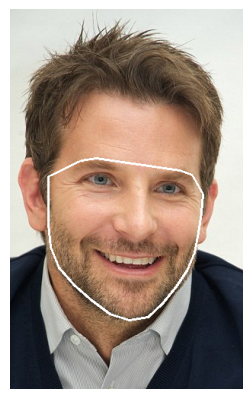

In [17]:
# Loading Models and Predictors of the 'dlib' Library to Detect Landmarks in Faces
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("./src/shape_predictor_68_face_landmarks.dat")

# Detecting Faces in the Destination Image
rects2 = detector(body_gray, 1)

if len(rects2) == 0:
    print("The Destination Image does not Have Any Face!")
    # Exit Program or Request a New Destination File!
else:
    print(len(rects2), "Destination Faces Detected:")

    # Defining A List of Convex Hulls and a List of Different 68-Landmark-Point Lists per Each Face
    convexhull2_all = []
    landmarks2_points_all = []

    for rect2 in rects2:  # For Each Face in the Destination Image
        landmarks2 = predictor(body_gray, rect2)
        landmarks2_points = []


        def get_landmarks(landmarks, landmarks_points):
            for n in range(68):
                x = landmarks2.part(n).x
                y = landmarks2.part(n).y
                landmarks2_points.append((x, y))


        # Landmarks are Stored in "landmarks2_points" and Appended in "landmarks2_points_all" List
        get_landmarks(landmarks2, landmarks2_points)
        landmarks2_points_all.append(landmarks2_points)

        # Generating a Convex Hull for the Current Face
        points2 = np.array(landmarks2_points, np.int32)
        convexhull2 = cv2.convexHull(points2)
        convexhull2_all.append(convexhull2)

    # Plotting the Destination Image and the Contour Shapes Drawn over the Faces Together
    body_cp = body.copy()
    i = body_cp.shape[1] / body_cp.shape[0]
    plt.figure(figsize=(int(6 * i), 6)); plt.axis('off')
    plt.imshow(cv2.cvtColor((cv2.polylines(body_cp, convexhull2_all, True, (255, 255, 255), 2)), cv2.COLOR_BGR2RGB))

    # The "convexhull2_all" and "landmarks2_points_all" Lists Generated from the Destination Faces will Be Used Later

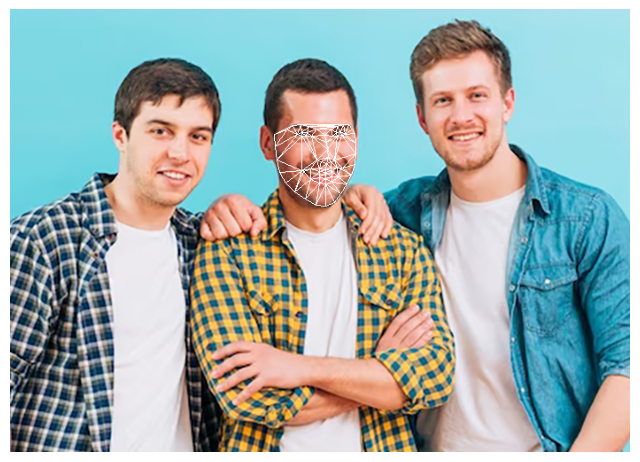

In [18]:
# Detecting Triangles in the Contour Regions of the Source Face

face_cp = face.copy()

rect = cv2.boundingRect(convexhull)
subdiv = cv2.Subdiv2D(rect)
subdiv.insert(landmarks_points)
triangles = subdiv.getTriangleList()
triangles = np.array(triangles, dtype=np.int32)


def get_index(arr):
    index = None
    for num in arr[0]:
        index = num
        break
    return index


indexes_triangles = []

for triangle in triangles:

    # Getting the Vertex of the Triangle
    pt1 = (triangle[0], triangle[1])
    pt2 = (triangle[2], triangle[3])
    pt3 = (triangle[4], triangle[5])

    # Drawing A Line for Each Side of the Triangle
    cv2.line(face_cp, pt1, pt2, (255, 255, 255), 1, 0)
    cv2.line(face_cp, pt2, pt3, (255, 255, 255), 1, 0)
    cv2.line(face_cp, pt3, pt1, (255, 255, 255), 1, 0)

    index_pt1 = np.where((points == pt1).all(axis=1))
    index_pt1 = get_index(index_pt1)

    index_pt2 = np.where((points == pt2).all(axis=1))
    index_pt2 = get_index(index_pt2)

    index_pt3 = np.where((points == pt3).all(axis=1))
    index_pt3 = get_index(index_pt3)

    # Saving Coordinates If the Triangle Exists and Has 3 Vertices
    if index_pt1 is not None and index_pt2 is not None and index_pt3 is not None:
        vertices = [index_pt1, index_pt2, index_pt3]
        indexes_triangles.append(vertices)  # This will Be Used in the Swapping Process

# Drawing Delaunay Triangles ove the Source Face
i = face_cp.shape[1] / face_cp.shape[0]
plt.figure(figsize=(int(6 * i), 6)); plt.axis('off')
plt.imshow(cv2.cvtColor(face_cp, cv2.COLOR_BGR2RGB));

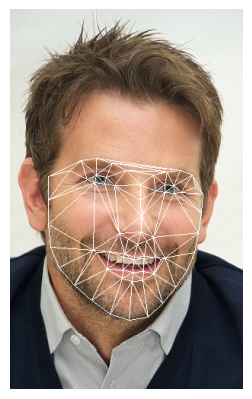

In [19]:
# Detecting Triangles in the Contour Regions of the Destination Faces

body_cp = body.copy()

for convexhull2, landmarks2_points in zip(convexhull2_all, landmarks2_points_all):

    rect2 = cv2.boundingRect(convexhull2)
    subdiv2 = cv2.Subdiv2D(rect2)
    subdiv2.insert(landmarks2_points)
    triangles2 = subdiv2.getTriangleList()
    triangles2 = np.array(triangles2, dtype=np.int32)


    def get_index(arr):
        index = None
        for num in arr[0]:
            index = num
            break
        return index


    for triangle in triangles2:
        # Getting the Vertex of the Triangle
        pt1 = (triangle[0], triangle[1])
        pt2 = (triangle[2], triangle[3])
        pt3 = (triangle[4], triangle[5])

        # Drawing A Line for Each Side of the Triangle
        cv2.line(body_cp, pt1, pt2, (255, 255, 255), 1, 0)
        cv2.line(body_cp, pt2, pt3, (255, 255, 255), 1, 0)
        cv2.line(body_cp, pt3, pt1, (255, 255, 255), 1, 0)

# Drawing Delaunay Triangles over the Destination Faces
i = body_cp.shape[1] / body_cp.shape[0]
plt.figure(figsize=(int(6 * i), 6)); plt.axis('off')
plt.imshow(cv2.cvtColor(body_cp, cv2.COLOR_BGR2RGB));

Mask of the Source Face for the Destination Face:


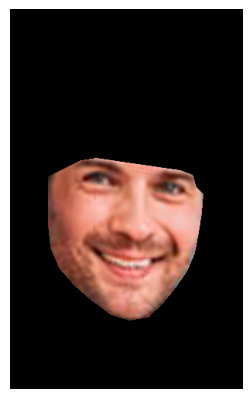

In [20]:
body_new_face_all = []

for landmarks2_points in landmarks2_points_all:
    switch_ = True

    # Creating Empty Matrices in the Shapes of Images
    height, width, channels = body.shape  # (h x w x c) is Obtained from the Destination Image
    body_new_face = np.zeros((height, width, channels), np.uint8)
    height, width = face_gray.shape  # h x w is Obtained from the Grayscale ver. of the Source
    mask = np.zeros((height, width), np.uint8)  # Mask is Formed from the Grayscale Version of the Source

    for triangle in indexes_triangles:
        # Coordinates of the Source Face's Delaunay Triangles
        pt1 = landmarks_points[triangle[0]]
        pt2 = landmarks_points[triangle[1]]
        pt3 = landmarks_points[triangle[2]]
        triangle1 = np.array([pt1, pt2, pt3], np.int32)

        # Getting the Delaunay Triangles
        (x, y, widht, height) = cv2.boundingRect(triangle1)
        cropped_triangle = face[y: y + height, x: x + widht]
        cropped_mask = np.zeros((height, widht), np.uint8)

        # Filling Triangles to Generate the Mask
        points = np.array([[pt1[0] - x, pt1[1] - y],
                           [pt2[0] - x, pt2[1] - y],
                           [pt3[0] - x, pt3[1] - y]], np.int32)
        cv2.fillConvexPoly(cropped_mask, points, 255)

        # Coordinates of the Destination Face's Delaunay Triangles
        pt1 = landmarks2_points[triangle[0]]
        pt2 = landmarks2_points[triangle[1]]
        pt3 = landmarks2_points[triangle[2]]
        triangle2 = np.array([pt1, pt2, pt3], np.int32)

        # Getting the Delaunay Triangles
        (x, y, widht, height) = cv2.boundingRect(triangle2)
        cropped_mask2 = np.zeros((height, widht), np.uint8)

        # Filling Triangles to Generate the Mask
        points2 = np.array([[pt1[0] - x, pt1[1] - y],
                            [pt2[0] - x, pt2[1] - y],
                            [pt3[0] - x, pt3[1] - y]], np.int32)
        cv2.fillConvexPoly(cropped_mask2, points2, 255)

        # Deforming the Triangles to Fit the Subject's Face
        points = np.float32(points)
        points2 = np.float32(points2)
        M = cv2.getAffineTransform(points, points2)
        dist_triangle = cv2.warpAffine(cropped_triangle, M, (widht, height))
        dist_triangle = cv2.bitwise_and(dist_triangle, dist_triangle, mask=cropped_mask2)

        # Joining All the Distorted Triangles to Make the Mask Fit in the Destination Face
        body_new_face_rect_area = body_new_face[y: y + height, x: x + widht]
        body_new_face_rect_area_gray = cv2.cvtColor(body_new_face_rect_area, cv2.COLOR_BGR2GRAY)

        # Creating A Face Mask
        masked_triangle = cv2.threshold(body_new_face_rect_area_gray, 1, 255, cv2.THRESH_BINARY_INV)
        dist_triangle = cv2.bitwise_and(dist_triangle, dist_triangle, mask=masked_triangle[1])

        # Adding the Pieces to the Face Mask
        body_new_face_rect_area = cv2.add(body_new_face_rect_area, dist_triangle)
        body_new_face[y: y + height, x: x + widht] = body_new_face_rect_area

    body_new_face_all.append(body_new_face)

# Combining All the Face Masks Together
adder = True
for body_new_face in body_new_face_all:
    if adder:
        body_new_full = body_new_face
        adder = False
    else:
        body_new_full = cv2.bitwise_or(body_new_full, body_new_face)

# Plotting the Mask
print("Mask of the Source Face for the Destination Face:")
i = body_new_full.shape[1] / body_new_full.shape[0]
plt.figure(figsize=(int(6 * i), 6)); plt.axis('off')
plt.imshow(cv2.cvtColor(body_new_full, cv2.COLOR_BGR2RGB));

Result of the Face Swap:


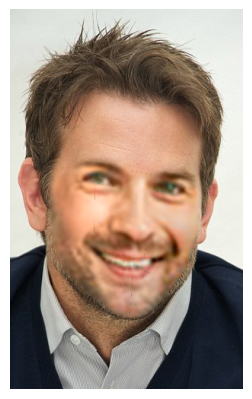

In [21]:
# Placing the Source Face over All the Detected Faces in the Destination Image

switch = True

for body_new_face, convexhull2 in zip(body_new_face_all, convexhull2_all):
    body_face_mask = np.zeros_like(body_gray)
    body_head_mask = cv2.fillConvexPoly(body_face_mask, convexhull2, 255)
    body_face_mask = cv2.bitwise_not(body_head_mask)

    (x, y, widht, height) = cv2.boundingRect(convexhull2)
    center_face2 = (int((x + x + widht) / 2), int((y + y + height) / 2))

    body_maskless = cv2.bitwise_and(body, body, mask=body_face_mask)
    result = cv2.add(body_maskless, body_new_face)

    if switch:
        seamlessclone = cv2.seamlessClone(result, body, body_head_mask, center_face2, cv2.NORMAL_CLONE)
        switch = False
    else:
        seamlessclone = cv2.seamlessClone(result, seamlessclone, body_head_mask, center_face2, cv2.NORMAL_CLONE)

# Plotting the Result Image
print("Result of the Face Swap:")
i = seamlessclone.shape[1] / seamlessclone.shape[0]
plt.figure(figsize=(int(6 * i), 6)); plt.axis('off')
plt.imshow(cv2.cvtColor(seamlessclone, cv2.COLOR_BGR2RGB));
cv2.imwrite("./images/result1.jpg", seamlessclone);

Source, Destination & Result Images Concatenated Horizontally:


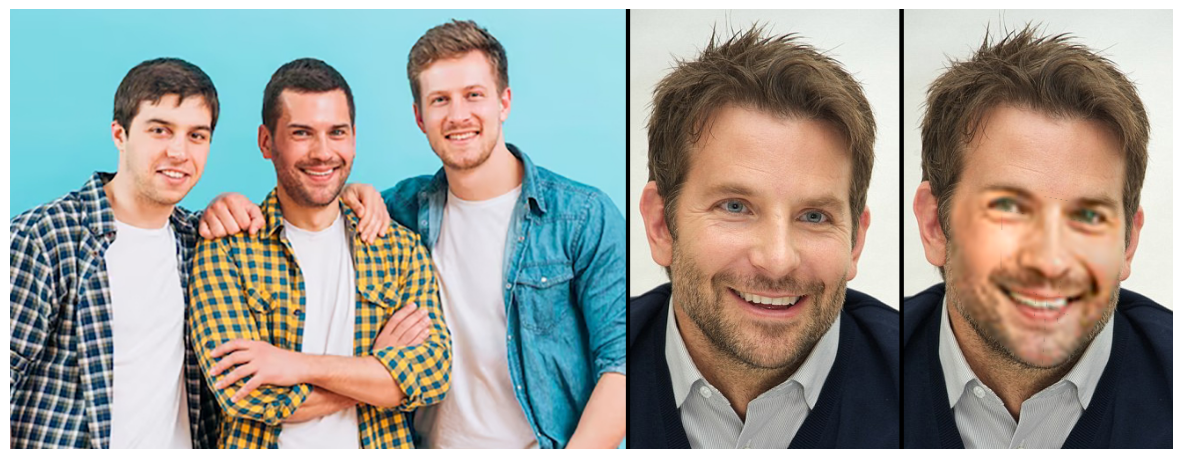

In [22]:
# Horizontal Concatenation of All the Images: Source, Destination, Result

h_s = face.shape[0]
w_s = face.shape[1]
h_n = body.shape[0]
w_n = int((h_n * w_s) / h_s)
border = np.zeros((h_n, int(h_n / 100), 3), dtype=np.uint8)

show_results = cv2.hconcat([cv2.resize(face, (w_n, h_n)), border, body, border, seamlessclone])

# Plotting All the Images Together: Source, Destination, Result
print("Source, Destination & Result Images Concatenated Horizontally:")
i = show_results.shape[1] / show_results.shape[0]
plt.figure(figsize=(int(6 * i), 6)); plt.axis('off')
plt.imshow(cv2.cvtColor(show_results, cv2.COLOR_BGR2RGB));